# Multi-trajectory workflow to Run Potential Step for CO Stripping.

Author: 

Joel W. Ager (jwager@lbl.gov, [ORCID](https://orcid.org/0000-0001-9334-9751)) [Group website](http://ager.mse.berkeley.edu), [GitHub](https://github.com/joelager)

Jinghan Li (mseljh@sjtu.edu.cn, [ORCID](https://orcid.org/0000-0003-3619-5121))

# Import packages, define units

In [1]:
# Files handling
import os
import glob
from pathlib import Path

# Code from the Zacros authors, must be in a subfolder of the code containing this notebook
import zacros_wrapper as zw

# Data analysis
import pandas as pd
import numpy as np
from units import * # Python script with SI units, cgs conversions, and physical constants # added the units conversion to the units.py

# Plot
import matplotlib.pyplot as plt

In [2]:
# Parameters used throughout simulations
T = 300*kelvin
Γ_sites = 1.32e15 * cm**-2

# Set directories

Set the directory with the notebook and the one with the zacros input files

In [3]:
######################### Change these for specific cases ##############################
notebook_wd = Path('C:/Users/mselj/Desktop/Paper/Paper-KMC/Upload-notebooks+simulation-files')
zacros_relative_file_location = Path('03-PS-Multi-SF')
zacros_wd = os.path.join(notebook_wd, zacros_relative_file_location)
os.chdir(zacros_wd)
glob.glob('*.dat')   # should list the 5 .dat files 

['energetics_input.dat',
 'lattice_input.dat',
 'mechanism_input.dat',
 'simulation_input.dat',
 'state_input.dat']

# Construct the run object, check input files

In [4]:
os.chdir(zacros_wd)

multi_1 = zw.KMC_Run.kmc_traj(path=zacros_wd)

n_sites = 100*100     ################################################ Remember to change #######################

multi_1.ReadAllInput()
print('Run exists: ', multi_1.CheckComplete())  # will be false if simulation has not run yet 
print('Number of surface species: {:d}'.format(multi_1.simin.n_surf))
print('Potential: {:.3f} V'.format(multi_1.simin.T - 10))     # note subtraction of offset
print('Simulation time: {:.3f} seconds'.format(multi_1.simin.SimTime_Max))
print('Lattice occupancy maps written every {:.3f} seconds'.format(multi_1.simin.hist[1]))
print('Process statistics written every {:.3f} seconds'.format(multi_1.simin.procstat[1]))
print('Species numbers written every {:.3f} seconds'.format(multi_1.simin.specnum[1]))

n_data_species = int(multi_1.simin.SimTime_Max/multi_1.simin.specnum[1] + 1)
print('Species numbers written {:d} times per trajectory'.format(n_data_species))

Run exists:  False
Number of surface species: 2
Potential: 0.275 V
Simulation time: 3.000 seconds
Lattice occupancy maps written every 0.050 seconds
Process statistics written every 0.050 seconds
Species numbers written every 0.050 seconds
Species numbers written 61 times per trajectory


In [5]:
 # The function for reading current and setting it into a numpy array.
def Current():
    ProOut = zw.IO_data.ProcstatOut()
    ProOut.ReadOut(zacros_wd)
    # print (ProOut.events.shape) # get the number of rows and lines
    ProcN = ProOut.t.shape[0]
    temp = ProOut.t.reshape (ProcN,1) # change the array of t into 2D array
    # print (temp.shape)
    temp1 = np.concatenate([temp, ProOut.events], axis = 1) # merge the 2 arrays
    df = pd.DataFrame(temp1) # change arrays to Dataframe.
    df.rename(columns={0: 'Time', 1: 'OH_adsorption', 2: 'OH_desorption', 3: 'CO_oxidation'},
                  inplace=True)
    df["abs"] = df.apply(lambda x: x["OH_adsorption"] - x["OH_desorption"] + x["CO_oxidation"], axis=1)
    df['+'] = df['abs'] - df['abs'].shift(1) # charge changes'
    df['current'] = df['+']*q*Γ_sites/(multi_1.simin.procstat[1]*n_sites*mA*cm**-2)
    df.head()
    current = np.array(df['current'])
    return current

In [6]:
os.chdir(zacros_wd)     # super double check we are in right place

n_trajectory = 10

print('**Beginning {:d} trajectories**'.format(n_trajectory))

for i in range(n_trajectory):
    print('Starting trajectory', i + 1)
    os.system('wsl.exe zacros-s.x')
    print('finished trajectory:', multi_1.CheckComplete())
    multi_1.ReadAllOutput(build_lattice=False)
    if i == 0:
        t_multi = multi_1.specnumout.t
        CO_vs_time = multi_1.specnumout.spec[:,0]  # Make new arrays the first time through
        OH_vs_time = multi_1.specnumout.spec[:,1]
        current_vs_time = Current() 

    else:
        CO_vs_time = np.vstack((CO_vs_time, multi_1.specnumout.spec[:,0]))
        OH_vs_time = np.vstack((OH_vs_time, multi_1.specnumout.spec[:,1]))
        current_vs_time = np.vstack((current_vs_time, Current()))

print('**finished simulation run**')

**Beginning 10 trajectories**
Starting trajectory 1
finished trajectory: True
Starting trajectory 2
finished trajectory: True
Starting trajectory 3
finished trajectory: True
Starting trajectory 4
finished trajectory: True
Starting trajectory 5
finished trajectory: True
Starting trajectory 6
finished trajectory: True
Starting trajectory 7
finished trajectory: True
Starting trajectory 8
finished trajectory: True
Starting trajectory 9
finished trajectory: True
Starting trajectory 10
finished trajectory: True
**finished simulation run**


In [7]:
# save the files
np.savetxt("CO_vs_time.csv", CO_vs_time, delimiter=',')
np.savetxt("OH_vs_time.csv", OH_vs_time, delimiter=',')
np.savetxt("current_vs_time.csv", current_vs_time, delimiter=',')

# Make some plots

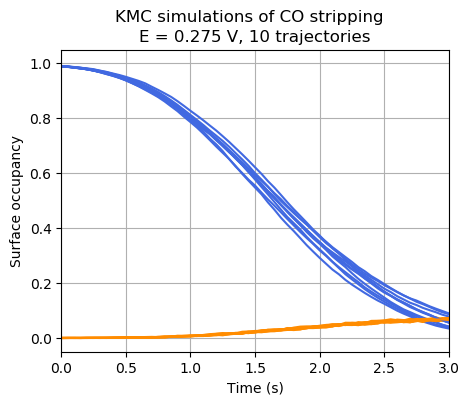

In [8]:
# overlap trajectories
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
fig.suptitle('KMC simulations of CO stripping')
ax.set_title('E = {:.3f} V, {} trajectories'.format(multi_1.simin.T - 10, n_trajectory))
for i in range(n_trajectory):
    plt.plot(t_multi, CO_vs_time[i]/n_sites, 'royalblue')
    plt.plot(t_multi, OH_vs_time[i]/n_sites, 'darkorange')
ax.set_xlabel('Time (s)')
ax.set_xlim(0, multi_1.simin.SimTime_Max)
ax.set_ylabel("Surface occupancy")
ax.set_ylim(-0.05,1.05)
ax.grid()
fig.savefig(os.path.join(zacros_wd,'coverage-multi.png'),dpi=600,format='png')

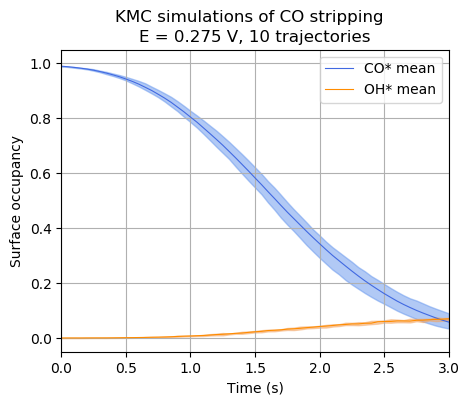

In [9]:
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
fig.suptitle('KMC simulations of CO stripping')
ax.set_title('E = {:.3f} V, {} trajectories'.format(multi_1.simin.T - 10, n_trajectory))

ax.plot(t_multi, np.mean(CO_vs_time, axis=0)/n_sites,'royalblue', linewidth=0.8, label='CO* mean')
ax.plot(t_multi, np.mean(OH_vs_time, axis=0)/n_sites,'darkorange', linewidth=0.8, label='OH* mean')
ax.fill_between(t_multi,
               np.amax(CO_vs_time/n_sites, axis=0),
               np.amin(CO_vs_time/n_sites, axis=0),
               color='cornflowerblue', alpha=0.5)
ax.fill_between(t_multi,
               np.amax(OH_vs_time/n_sites, axis=0),
               np.amin(OH_vs_time/n_sites, axis=0),
               color='sandybrown', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_xlim(0, multi_1.simin.SimTime_Max)
ax.set_ylabel("Surface occupancy")
ax.set_ylim(-0.05,1.05)
ax.legend()
ax.grid()
fig.savefig(os.path.join(zacros_wd,'coverage-mean.png'),dpi=600,format='png')

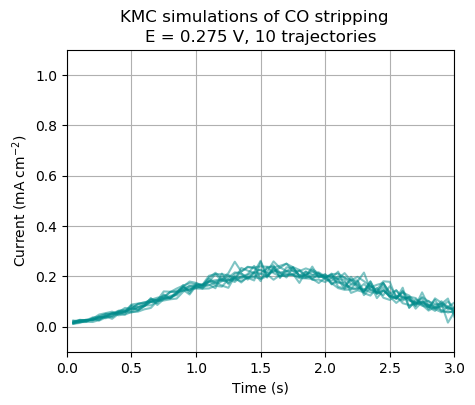

In [10]:
# overlap trajectories
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
fig.suptitle('KMC simulations of CO stripping')
ax.set_title('E = {:.3f} V, {} trajectories'.format(multi_1.simin.T - 10, n_trajectory))
for i in range(n_trajectory):
    plt.plot(t_multi, current_vs_time[i],'darkcyan',alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (mA cm$^{-2}$)')
ax.set_xlim(0, multi_1.simin.SimTime_Max)
ax.set_ylim(-0.1,1.1)
ax.grid()
fig.savefig(os.path.join(zacros_wd,'current-multi.png'),dpi=600,format='png')

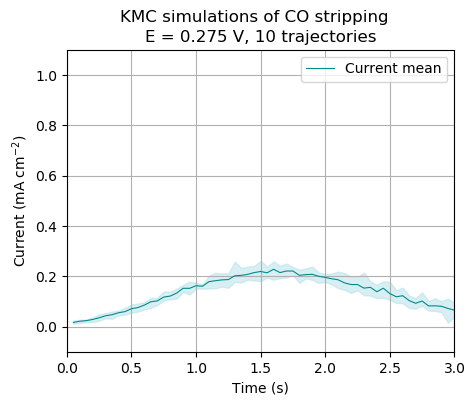

In [11]:
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
fig.suptitle('KMC simulations of CO stripping')
ax.set_title('E = {:.3f} V, {} trajectories'.format(multi_1.simin.T - 10, n_trajectory))

ax.plot(t_multi, np.mean(current_vs_time, axis=0),'darkcyan', linewidth=0.8, label='Current mean')
ax.fill_between(t_multi,
               np.amax(current_vs_time, axis=0),
               np.amin(current_vs_time, axis=0),
               color='powderblue', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (mA cm$^{-2}$)')
ax.set_xlim(0, multi_1.simin.SimTime_Max)
ax.set_ylim(-0.1,1.1)
ax.legend()
ax.grid()
fig.savefig(os.path.join(zacros_wd,'current-mean.png'),dpi=600,format='png')

Shaded regions shows minimum and maximum.